# Recommender System -- collaborative filter

In [1]:
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import time

D:\anaconda\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Data preprocess
https://grouplens.org/datasets/movielens/

In [2]:
df = pd.read_csv('./data/ratings.dat', sep='::', header=None, engine='python')
df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
df.shape

(1000209, 4)

In [4]:
all_user_cnt = len(df.user_id.unique())
all_user_cnt

6040

In [5]:
all_movies = set(df.movie_id.unique())
all_movie_cnt = len(all_movies)
all_movie_cnt

3706

### Train test slipt

In [6]:
X, y = df[['user_id', 'movie_id']].values, df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/8, random_state=0)

In [7]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(875182, 2) (875182,) (125027, 2) (125027,)


In [8]:
movie_popularity = defaultdict(int)
for _, m_id in X_train:
    movie_popularity[m_id] += 1

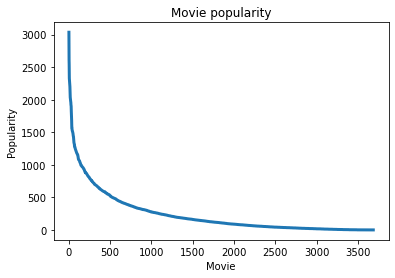

In [9]:
sorted_movie_popularity = sorted(movie_popularity.items(), key=lambda x: x[1], reverse=True)
plt.plot(list(map(lambda x: x[1], sorted_movie_popularity)), linewidth=3)
plt.title('Movie popularity')
plt.ylabel('Popularity')
plt.xlabel('Movie')
plt.show()

## User based
Just consider the interaction but not rating

In [10]:
def get_user_movies(data):
    user_movies = defaultdict(set)
    for u_id, m_id in data:
        user_movies[u_id].add(m_id)
    return user_movies

In [11]:
user_movies_train = get_user_movies(X_train)
user_movies_test = get_user_movies(X_test)

### User similarity

In [12]:
def calc_user_similarity(user_movies):
    res = defaultdict(dict)
    user_ids = user_movies.keys()
    for u in tqdm  (user_ids):
        for v in user_ids:
            if u < v:
                res[v][u] = res[u][v] = len(user_movies[u] & user_movies[v]) / np.sqrt(len(user_movies[u]) * len(user_movies[v]))
    return res

In [13]:
start = time.time()
user_similarities = calc_user_similarity(user_movies_train)
print(time.time() - start)

100%|██████████| 6040/6040 [01:58<00:00, 50.84it/s]

118.83343744277954


### Recommend item for user

In [14]:
def recommend(user, user_movies, user_similarities, k):
    res = defaultdict(float)
    # Calculate top k similar users
    sorted_users = sorted(user_similarities[user].items(), key=lambda x: x[1], reverse=True)
    top_users = sorted_users[:k]
    u_movies = user_movies[user]
    for v, wuv in top_users:
        v_movies = user_movies[v]
        for m_id in v_movies:
            if m_id not in u_movies:
                res[m_id] += wuv * 1.0
    return list(map(lambda x: x[0], sorted(res.items(), key=lambda x: x[1], reverse=True)))

## Evaluate

In [15]:
# precision, recall, coverage
def calc_metrics(user_movies, user_movies_reco, all_movie_cnt, n=None):
    label_all, reco_all, hit = 0, 0, 0
    all_movies_reco = []
    for u_id in user_movies:
        label_movies = user_movies[u_id]
        reco_movies = user_movies_reco[u_id][:n] if n else user_movies_reco[u_id]
        all_movies_reco += reco_movies
        reco_movies = set(reco_movies)
        label_all += len(label_movies)
        reco_all += len(reco_movies)
        hit += len(label_movies & reco_movies)
    return {
        'precision': hit / reco_all,
        'recall': hit / label_all,
        'coverage': len(set(all_movies_reco)) / all_movie_cnt
    }

In [16]:
user_movies_reco = {}
k = 10
for u_id in user_movies_test:
    user_movies_reco[u_id] = recommend(u_id, user_movies_train, user_similarities, k)

In [17]:
calc_metrics(user_movies_test, user_movies_reco, all_movie_cnt, n = 20)

{'precision': 0.16812802133688948,
 'recall': 0.1613411503115327,
 'coverage': 0.5118726389638424}

### For top n items

In [18]:
metrics_n = {}
for n in range(5, 50, 5):
    metrics_n[n] = calc_metrics(user_movies_test, user_movies_reco, all_movie_cnt, n = n)

In [19]:
pd.DataFrame(metrics_n)

,5,10,15,20,25,30,35,40,45
precision,0.237873,0.203934,0.183064,0.168128,0.155746,0.145802,0.137366,0.130605,0.124499
recall,0.057068,0.097851,0.131756,0.161341,0.186824,0.209875,0.230686,0.250666,0.268814
coverage,0.325148,0.414463,0.467350,0.511873,0.549919,0.580140,0.611981,0.636266,0.662169


In [20]:
n = 10

### For top n users

In [21]:
metrics = {}
k_list = [5, 10, 20, 40, 80, 160]
for i in tqdm(range(len(k_list))):
    k = k_list[i]
    user_movies_reco = {}
    for u in user_movies_test:
        user_movies_reco[u] = recommend(u, user_movies_train, user_similarities, k)
    metrics[k] = calc_metrics(user_movies_test, user_movies_reco, all_movie_cnt, n = n)

100%|██████████| 6/6 [05:37<00:00, 56.32s/it]


In [24]:
pd.DataFrame(metrics)

,5,10,20,40,80,160
precision,0.168028,0.203934,0.228338,0.243807,0.251375,0.247841
recall,0.080623,0.097851,0.109560,0.116983,0.120614,0.118918
coverage,0.522396,0.414463,0.332164,0.261198,0.202105,0.155424


In [25]:
k = 80

### Compare with random method

In [26]:
reco_random = {}
for u_id in user_movies_test:
    movies = all_movies - user_movies_train[u_id]
    reco_random[u_id] = random.sample(movies, n)
metrics_c = {'random': calc_metrics(user_movies_test, reco_random, all_movie_cnt)}

In [27]:
# most popular method
popular_movies = list(map(lambda x: x[0], sorted(movie_popularity.items(), key=lambda x: x[1], reverse=True)))

reco_popular = {}
for u_id in user_movies_test:
    user_movies = user_movies_train[u_id]
    reco_movies = set()
    cnt = 0
    for m_id in popular_movies:
        if m_id not in user_movies:
            reco_movies.add(m_id)
            cnt += 1
            if cnt == n:
                break
    reco_popular[u_id] = reco_movies
metrics_c['popular'] = calc_metrics(user_movies_test, reco_popular, all_movie_cnt)

In [28]:
pd.DataFrame(metrics_c)

,random,popular
precision,0.006684,0.127021
recall,0.003207,0.060947
coverage,1.000000,0.024015


## Improved the cosine similarity

In [29]:
# Use rating
def calc_user_similarity_improved(user_movies, movie_popularity):
    res = defaultdict(dict)
    user_ids = user_movies.keys()
    for u in tqdm(user_ids):
        for v in user_ids:
            if u < v:
                res[v][u] = res[u][v] = np.sum(list(map(lambda x: 1 / np.log(1 + movie_popularity[x]), user_movies[u] & user_movies[v]))) / np.sqrt(len(user_movies[u]) * len(user_movies[v]))
    return res

In [30]:
start = time.time()
user_similarities_improved = calc_user_similarity_improved(user_movies_train, movie_popularity)
print(time.time() - start)

100%|██████████| 6040/6040 [11:26<00:00,  8.79it/s]

686.9203343391418


In [31]:
user_movies_reco = {}
k = 80
for u_id in tqdm(user_movies_test):
    user_movies_reco[u_id] = recommend(u_id, user_movies_train, user_similarities_improved, k)

100%|██████████| 5999/5999 [01:23<00:00, 72.18it/s] 


In [32]:
calc_metrics(user_movies_test, user_movies_reco, all_movie_cnt, n = 10)

{'precision': 0.2521753625604267,
 'recall': 0.12099786446127636,
 'coverage': 0.21532649757150565}